<a href="https://colab.research.google.com/github/GKS07/Computer_Vision/blob/main/Gender_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#downloading the data.


# uploading the kaggle jason file
from google.colab import files
files.upload()

# copying the kaggle file

!mkdir ~/.kaggle # nmaking the folder

! cp kaggle.json ~/.kaggle/  #copy the file

#changing the permission.
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d trainingdatapro/gender-detection-and-classification-image-dataset

# making the folder
!mkdir gender_data


 96% 584M/606M [00:04<00:00, 105MB/s]
100% 606M/606M [00:04<00:00, 129MB/s]


In [ ]:
#unzipping the data

!unzip gender-detection-and-classification-image-dataset.zip -d gender_data

<h2>Importing the Libraries. </h2>

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense, Rescaling
from tensorflow.keras.activations import relu, sigmoid
import seaborn as sns
import keras
from tensorflow.keras.applications import VGG19


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Loading and Preprocessing the Images.

In [5]:
training_path = '/content/gender_data/train'

test_path = '/content/gender_data/test'

In [6]:
# number of images in each foldersn of training data.

for sub_dir in os.listdir(training_path):
    img_file = os.listdir(os.path.join(training_path,sub_dir))
    print(sub_dir)
    print("The number of",sub_dir,"is:", len(img_file))

men
The number of men is: 110
women
The number of women is: 110


the dataset is too small so we need to augment the  data.

2 classes:
['men', 'women']


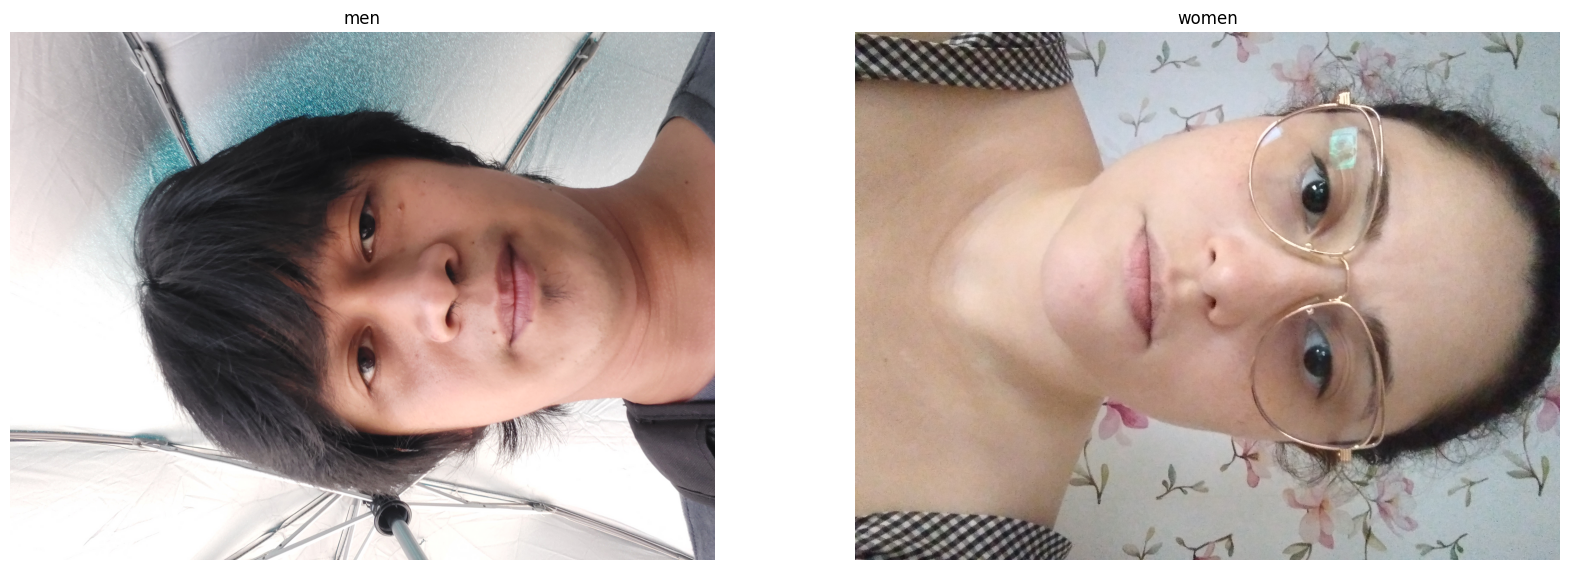

In [7]:
#plotting the images from both calsses.

classes = os.listdir(training_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(20, 60))
i = 0
for sub_dir in os.listdir(training_path):
    i+=1
    img_file = os.listdir(os.path.join(training_path,sub_dir))[0]
    img_path = os.path.join(training_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(sub_dir)
plt.show()

#creating  a training and validation data

In [34]:
#creating a function for training and validation data

img_size = 224
batch_size = 15


def training_validation_data(path_of_data):

  img_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg19.preprocess_input ,#this will convert the input images from RGB to BGR
                                     #zoom_range = 0.2,
                                     #shear_range = 0.2,
                                    # horizontal_flip = True,
                                     #vertical_flip = True,
                                     #rotation_range = 40,
                                     #featurewise_center = True,
                                     #featurewise_std_normalization = True,
                                     #brightness_range = [0.3, 0.5],
                                     #width_shift_range = 0.3,
                                     #height_shift_range = 0.3
                                     )


  processed_data = img_generator.flow_from_directory(path_of_data,
                                                     target_size = (img_size, img_size),
                                                     #color_mode = 'rgb',
                                                     batch_size = batch_size,
                                                     shuffle = True,
                                                     class_mode = 'categorical')

  return processed_data


In [35]:
training_data = training_validation_data(training_path)

validation_data = training_validation_data(test_path)

Found 220 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [10]:
training_data.image_shape

(224, 224, 3)

In [11]:
CLASSES  = [x for x in training_data.class_indices]
CLASSES

['men', 'women']

**Visualising the training data**

In [12]:
# function for displaying the images.

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)

# plotting the 9 images
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(20,15))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

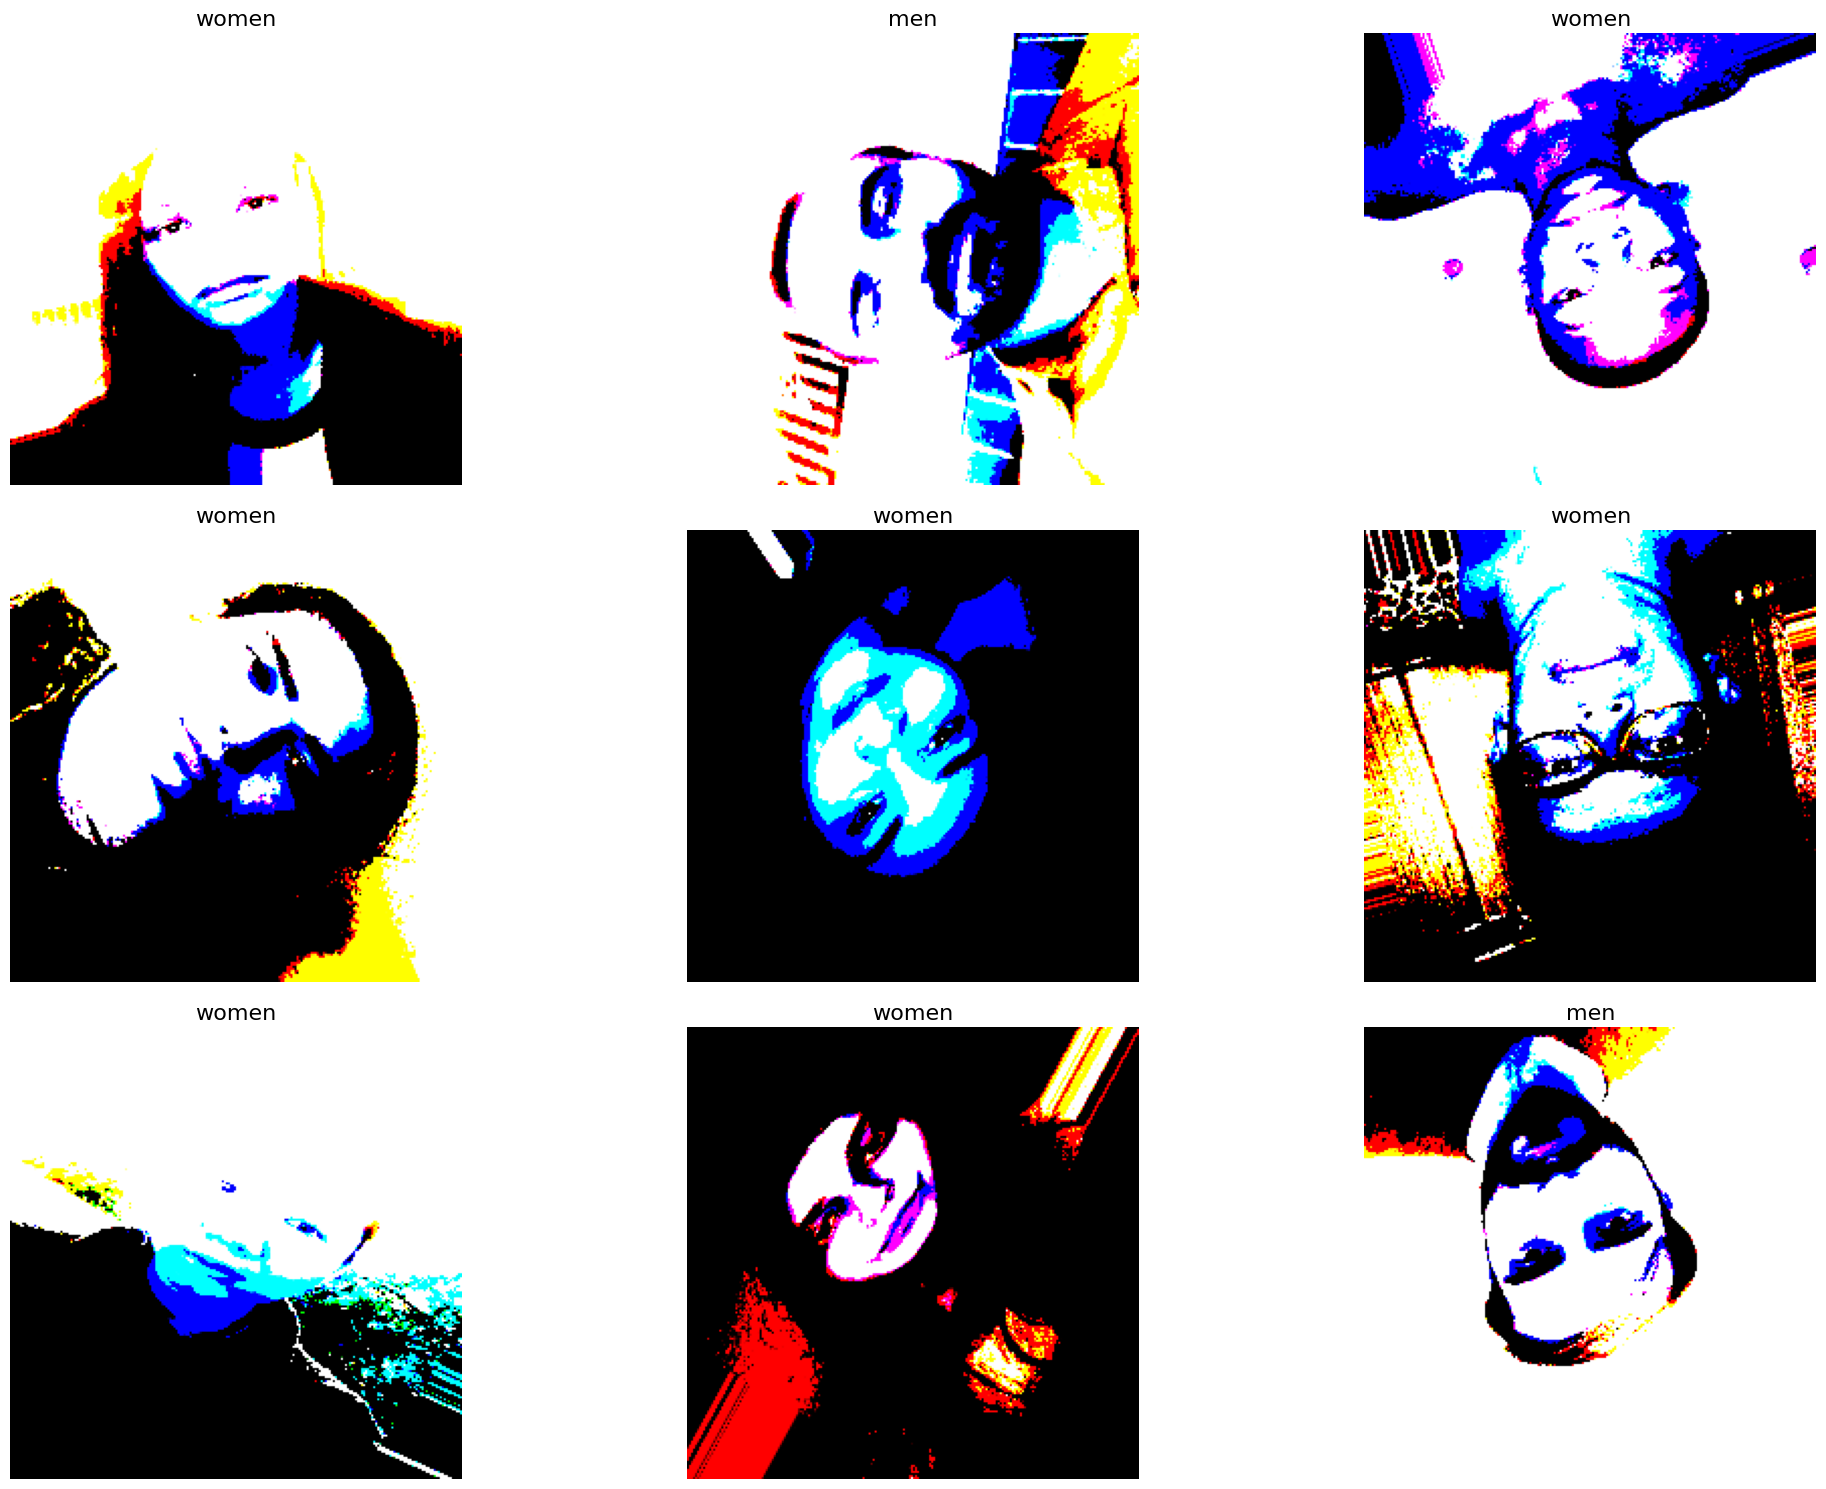

In [13]:
#displaying the training images.

images, classes = next(training_data)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

# Augmenting the Images

In [14]:
# augmenting the data.

augmented_images = Sequential([
                         layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                         layers.experimental.preprocessing.RandomRotation(0.4),
                         layers.experimental.preprocessing.RandomZoom(0.4),
                         #layers.RandomBrightness(0.4),
                         layers.experimental.preprocessing.RandomContrast(0.3),
                         ], name = "augmenting_layer")


In [22]:
#Initialising the VGG19 pretrained model:

base_model = VGG19(include_top = False,
                   input_shape = training_data.image_shape,
                   weights = 'imagenet',
                   pooling = 'max')


In [19]:
# number of layers in VGG19 model.

len(base_model.layers)

23

In [29]:
#freezing the layers training of base model

base_model.trainable = False
for i, layer in enumerate(base_model.layers):
  base_model.layers[i].trainable = False

In [32]:
# creating the model to fit on top of the pretrained model.
inputs = layers.Input(shape = training_data.image_shape, name='inputLayer')
x = augmented_images(inputs)
pretrain_out = base_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(1)(x)
outputs = layers.Activation(activation="sigmoid", name='activationLayer')(x)
model = keras.models.Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00000000000000000003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 augmenting_layer (Sequenti  (None, None, None, None   0         
 al)                         )                                   
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                          

In [36]:
#fitting the model with training data
callback = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
EPOCHS = 10

with tf.device('/device:GPU:0'):
  history = model.fit(training_data,
                      validation_data = validation_data,
                      callbacks = [callback],
                      epochs = EPOCHS)

Epoch 1/10
15/15 [==============================] - 21s 1s/step - loss: 0.9685 - accuracy: 0.5000 - val_loss: 2.5125 - val_accuracy: 0.5000
Epoch 2/10
15/15 [==============================] - 25s 2s/step - loss: 1.0189 - accuracy: 0.5000 - val_loss: 2.3107 - val_accuracy: 0.5000
Epoch 3/10
15/15 [==============================] - 21s 1s/step - loss: 0.9694 - accuracy: 0.5000 - val_loss: 2.2131 - val_accuracy: 0.5000
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.9889 - accuracy: 0.5000 - val_loss: 2.0033 - val_accuracy: 0.5000


In [38]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])



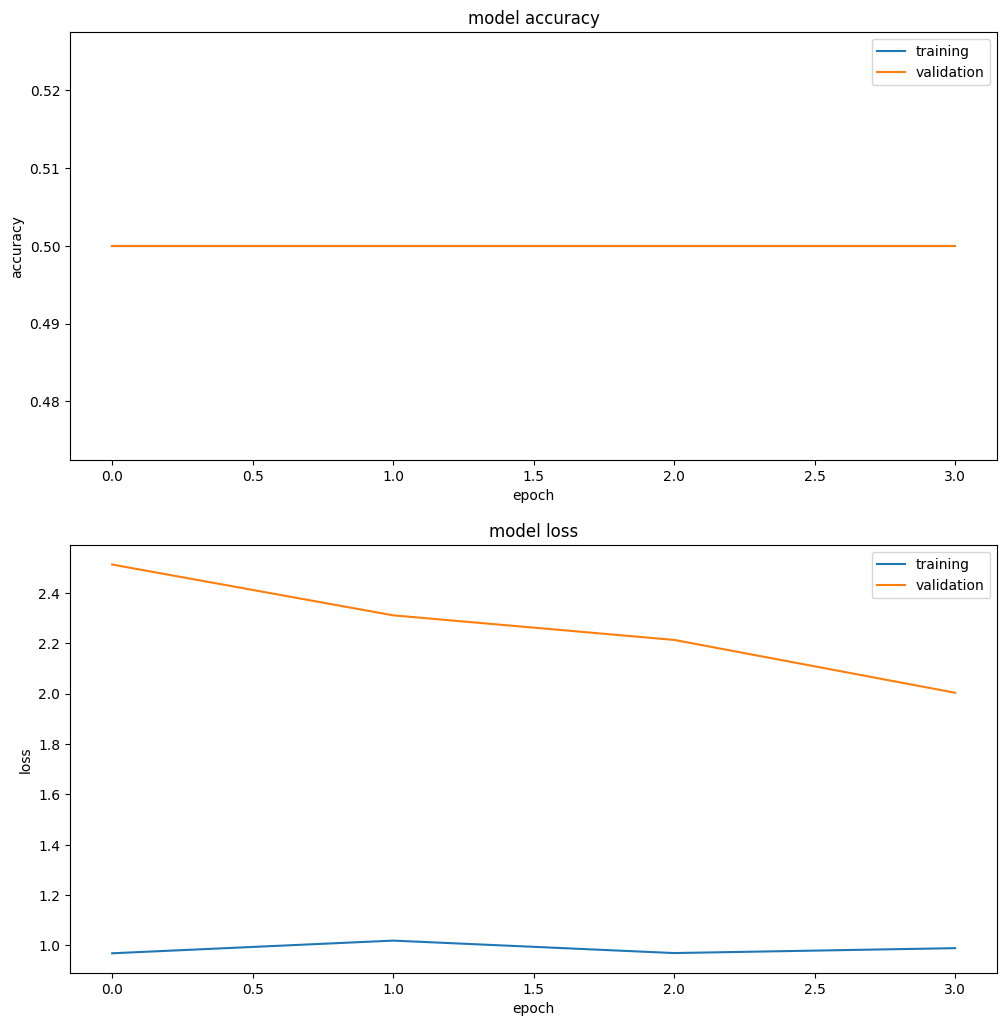

In [39]:
plt.subplots(figsize=(10,10))
plt.tight_layout()

display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)
